In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [ ]:
# 1. LOAD DATA

Dataset shape: (35, 5)


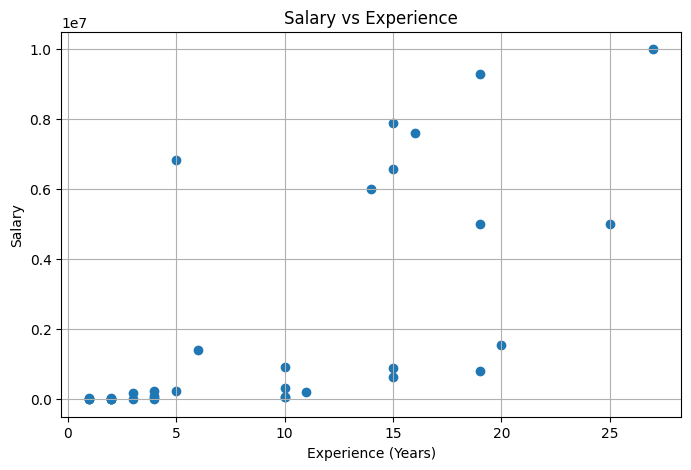

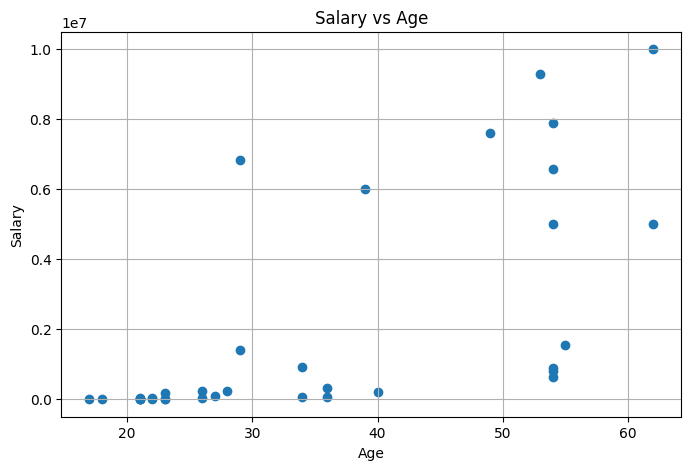

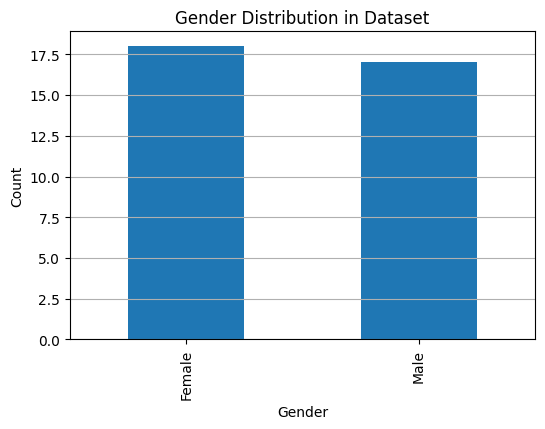

In [ ]:
DATA_PATH = Path("data.csv")
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

df = df.drop(columns=["ID"], errors="ignore")

df = df.dropna(subset=["Salary"])
TEXT_COL = None  # no job title or text column
NUMERIC_COLS = ["Experience_Years", "Age"]
CAT_COLS = ["Gender"]
TARGET = "Salary"


# sal vs exp
plt.figure(figsize=(8,5))
plt.scatter(df["Experience_Years"], df["Salary"])
plt.xlabel("Experience (Years)")
plt.ylabel("Salary")
plt.title("Salary vs Experience")
plt.grid(True)
plt.show()

# sal vs avg
plt.figure(figsize=(8,5))
plt.scatter(df["Age"], df["Salary"])
plt.xlabel("Age")
plt.ylabel("Salary")
plt.title("Salary vs Age")
plt.grid(True)
plt.show()

# gender
plt.figure(figsize=(6,4))
df["Gender"].value_counts().plot(kind="bar")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution in Dataset")
plt.grid(axis="y")
plt.show()

In [ ]:
# 2. DEFINE FEATURES AND TARGET

In [ ]:
NUMERIC_COLS = ["Experience_Years", "Age"]
CAT_COLS = ["Gender"]
TARGET = "Salary"

X = df[NUMERIC_COLS + CAT_COLS]
y = df[TARGET]


In [ ]:
# 3. TRAIN-TEST SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

Train size: (28, 3) | Test size: (7, 3)


In [ ]:
# 4. PREPROCESSING PIPELINES

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, NUMERIC_COLS),
    ("cat", categorical_transformer, CAT_COLS)
])

In [ ]:
# 5. MODEL DEFINITIONS

In [ ]:
lr = Pipeline(steps=[
    ("pre", preprocessor),
    ("reg", LinearRegression())
])

rf = Pipeline(steps=[
    ("pre", preprocessor),
    ("reg", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

gb = Pipeline(steps=[
    ("pre", preprocessor),
    ("reg", GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42))
])

voting = Pipeline(steps=[
    ("pre", preprocessor),
    ("reg", VotingRegressor([
        ("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
        ("gb", GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)),
        ("lr", LinearRegression())
    ]))
])

In [ ]:
# 6. CROSS-VALIDATION FUNCTION

In [ ]:
def evaluate_model(name, model, X, y):
    print(f"\n{name}")
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5, n_jobs=-1))
    r2 = cross_val_score(model, X, y, scoring="r2", cv=5, n_jobs=-1)
    print(f"RMSE (mean ± std): {rmse.mean():.2f} ± {rmse.std():.2f}")
    print(f"R² (mean ± std):   {r2.mean():.4f} ± {r2.std():.4f}")

In [ ]:
# 7. CROSS-VALIDATION SCORES

In [ ]:
evaluate_model("Linear Regression", lr, X_train, y_train)
evaluate_model("Random Forest", rf, X_train, y_train)
evaluate_model("Gradient Boosting", gb, X_train, y_train)
evaluate_model("Voting Regressor", voting, X_train, y_train)


Linear Regression
RMSE (mean ± std): 2920370.06 ± 373768.16
R² (mean ± std):   -5.3490 ± 11.0281

Random Forest
RMSE (mean ± std): 3380656.11 ± 752359.16
R² (mean ± std):   -3.6091 ± 6.7773

Gradient Boosting
RMSE (mean ± std): 3858300.18 ± 1185481.17
R² (mean ± std):   -3.8918 ± 6.5380

Voting Regressor
RMSE (mean ± std): 3281165.55 ± 648065.35
R² (mean ± std):   -3.9560 ± 7.6572


In [ ]:
# 8. FINAL MODEL TRAINING (VOTING ENSEMBLE)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate on test set
y_pred = voting.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)  # RMSE manually
r2_test = r2_score(y_test, y_pred)

print("\nTest Results (Voting Ensemble):")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²:   {r2_test:.4f}")


Test Results (Voting Ensemble):
RMSE: 921362.01
R²:   -58.6701


In [ ]:
# 9. FEATURE IMPORTANCE (RANDOM FOREST)

In [ ]:
cat_features = voting.named_steps["pre"].named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(CAT_COLS)
all_features = NUMERIC_COLS + list(cat_features)

rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(voting.named_steps["pre"].transform(X_train), y_train)

importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
print("\nTop Feature Importances:\n", feat_imp)


Top Feature Importances:
 Experience_Years    0.518957
Age                 0.423258
Gender_Male         0.030761
Gender_Female       0.027024
dtype: float64


In [ ]:
# 10. SAVE MODEL

In [ ]:
joblib.dump(voting, "salary_prediction_model.joblib")
print("\nModel saved as salary_prediction_model.joblib")


Model saved as salary_prediction_model.joblib


In [ ]:
# testing

In [ ]:
new_employee = pd.DataFrame({
    "Experience_Years": [5],
    "Age": [28],
    "Gender": ["Male"]
})

# Predict salary using the trained Voting model
predicted_salary = voting.predict(new_employee)
print("Predicted Salary:", predicted_salary[0])

Predicted Salary: 1271278.0892266303
